In [1]:
import sys
sys.path.append("C:/Users/timlf/PycharmProjects/Semester_Project_Too/LIFE-Retrieval-Framework/pyretlife/retrieval_plotting/")

from run_plotting import retrieval_plotting_object



problem: Could not find module 'libmultinest.dll' (or one of its dependencies). Try using the full path with constructor syntax.


SystemExit: 1

C:\Users\timlf\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [1]:
import os
print(os.environ.get("PATH"))

C:\Users\timlf\PycharmProjects\Semester_Project_Too\.venv\Scripts;C:\WINDOWS\system32;C:\WINDOWS;C:\WINDOWS\System32\Wbem;C:\WINDOWS\System32\WindowsPowerShell\v1.0\;C:\WINDOWS\System32\OpenSSH\;C:\Program Files\ffmpeg-7.1-essentials_build\bin;C:\TDM-GCC-64\bin;C:\Program Files\Git\cmd;C:\Users\timlf\AppData\Local\Programs\Python\Launcher\;C:\Users\timlf\AppData\Local\Microsoft\WindowsApps;C:\Users\timlf\AppData\Roaming\Programs\Zero Install;C:\Users\timlf\AppData\Local\GitHubDesktop\bin;C:\msys64\mingw64\bin;


In [1]:
import sys, platform
print("Python executable:", sys.executable)
print("Platform:", platform.system())

Python executable: /home/timlf/myenv/bin/python
Platform: Linux


In [4]:
from pyretlife import *

In [1]:
import pyretlife
print(pyretlife.__file__)

/home/timlf/software/pyRetLIFE/pyretlife/__init__.py


In [1]:
from argparse import ArgumentParser, Namespace
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.ndimage import gaussian_filter

from pyretlife.retrieval_plotting.run_plotting import retrieval_plotting_object
from pyretlife.retrieval_plotting.posterior_plotting import (
    Generate_Parameter_Titles,
    Scale_Posteriors
)

In [9]:
def get_cli_arguments(arg_list: list[str] | None = None) -> Namespace:
    parser = ArgumentParser(description="Run nested sampling with configuration options.")

    parser.add_argument(
        "--config",
        required=True,
        type=str,
        help="Path to the configuration file."
    )

    parser.add_argument(
        "--nproc",
        required=True,
        type=int,
        help="Number of processes to use."
    )

    parser.add_argument(
        "--sampler",
        required=False,
        type=str,
        choices=["MultiNest", "Nautilus"],
        default="MultiNest",
        help="Nested sampling algorithm (default: MultiNest)."
    )

    return parser.parse_args(arg_list)


# Example: simulate command-line arguments directly in code
args = get_cli_arguments(["--config", "/mnt/d/timlf/Tim Daten/Desktop/VH2O_CL_gauss10/input_new.yaml", "--nproc", "4", "--sampler", "MultiNest"])

print(args)
print(args.config, args.nproc, args.sampler)

Namespace(config='/mnt/d/timlf/Tim Daten/Desktop/VH2O_CL_gauss10/input_new.yaml', nproc=4, sampler='MultiNest')
/mnt/d/timlf/Tim Daten/Desktop/VH2O_CL_gauss10/input_new.yaml 4 MultiNest


In [2]:
from pyretlife.retrieval_plotting.run_plotting import retrieval_plotting_object
# results = retrieval_plotting_object('/mnt/d/timlf/Tim Daten/Desktop/VH2O_CL_gauss10/')

In [4]:
results.calculate_posterior_pt_profile(n_processes=min([200,int(args.nproc)]),reevaluate_PT=False)

results.calculate_posterior_spectrum(n_processes=min([200,int(args.nproc)]),reevaluate_spectra=False)

results.deduce_bond_albedo(stellar_luminosity=1.0,
										error_stellar_luminosity=0.01,
                                        planet_star_separation=1.0,
                                        error_planet_star_separation=0.01,
                                        true_equilibrium_temperature = 255,
                                        true_bond_albedo = 0.29,
                                        reevaluate_bond_albedo=False)
results.deduce_abundance_profiles(reevaluate_abundance_profiles=False)

results.deduce_gravity(true_gravity = 981)
results.deduce_surface_temperature(true_surface_temperature = 273)

unit_titles = {'R_pl':'$\mathrm{R_{Earth}}$','M_pl':'$\mathrm{M_{Earth}}$'}

Loaded previously calculated PT profiles from /mnt/d/timlf/Tim Daten/Desktop/VH2O_CL_gauss10/Plots_New/Ret_PT_Skip_1.pkl.

Loaded previously calculated spectra from /mnt/d/timlf/Tim Daten/Desktop/VH2O_CL_gauss10/Plots_New/Ret_Spec_Skip_1.pkl.

Loaded previously calculated Bond albedos from /mnt/d/timlf/Tim Daten/Desktop/VH2O_CL_gauss10/Plots_New/Ret_Bond_Albedo.pkl.

Loaded previously calculated abundance profiles from /mnt/d/timlf/Tim Daten/Desktop/VH2O_CL_gauss10/Plots_New/Ret_Abundance_Profiles.pkl.



In [18]:
def copy_spectrum(directory):
    matches = [
        f for f in glob.glob(os.path.join(directory, "input_*.txt"))
        if os.path.basename(f) != "input_spectrum.txt"]
    if matches:
        source = matches[0]
        destination = os.path.join(directory, "input_spectrum.txt")
        shutil.copy(source, destination)

def load_data(
        self,
        log_pressures=True,
        log_mass=True,
        log_abundances=True,
        log_particle_radii=True,
        plot_pt=True,
        plot_physparam=True,
        plot_clouds=True,
        plot_chemcomp=True,
        plot_scatt=True,
        plot_moon=False,
        plot_secondary_parameters=True,
        parameter_units='input',
        custom_unit_titles={},
        custom_parameter_titles={}
):
    """
    Loads and returns the data for the retrieved parameters as well as the upper-log-uniform (ULU), the truth values and the parameter names.

    Parameters
    ----------
    log_pressures :  bool, optional
        If True, applies a logarithmic scale to pressure values. Defaults to True.

    log_mass : bool, optional
        If True, applies a logarithmic scale to mass values. Defaults to True.

    log_abundances :  bool, optional
        If True, applies a logarithmic scale to abundance values. Defaults to True.

    log_particle_radii : bool, optional
        If True, applies a logarithmic scale to particle radii values. Defaults to True.

    plot_pt :  bool, optional
        If True, plots pressure-temperature parameters. Defaults to True.

    plot_physparam : bool, optional
        If True, plots physical parameters. Defaults to True.

    plot_clouds :  bool, optional
        If True, plots cloud parameters. Defaults to True.

    plot_chemcomp : bool, optional
        If True, plots chemical composition parameters. Defaults to True.

    plot_scatt : bool, optional
        If True, plots scattering parameters. Defaults to True.

    plot_moon :  bool, optional
        If True, plots moon parameters. Defaults to False.

    plot_secondary_parameters : bool, optional
        If True, plots secondary parameters. Defaults to True.

    parameter_units : str, optional
        The units to use for plotting. Defaults to 'input', which are the units specified in the config file.

    custom_unit_titles : dict, optional
        A dictionary mapping parameters to custom unit titles. Defaults to an empty dictionary.

    custom_parameter_titles={} : dict, optional
        A dictionary mapping parameters to custom titles. Defaults to an empty dictionary.
    """

    recompute = False
    self.calculate_posterior_spectrum(reevaluate_spectra=False)
    if np.shape(self.retrieved_fluxes)[0] != np.shape(self.posteriors)[0]:
        print('reevaluating spectrum due to dimension error.')
        delattr(self, 'retrieved_fluxes')
        self.calculate_posterior_spectrum(reevaluate_spectra=True)
        recompute = True
        # copy_spectrum(self.results_directory)

    try:
        self.calculate_posterior_pt_profile(n_processes=4,reevaluate_PT=recompute)

        self.deduce_bond_albedo(stellar_luminosity=1.0,
                            	error_stellar_luminosity=0.01,
                            	planet_star_separation=1.0,
                        		error_planet_star_separation=0.01,
                        		true_equilibrium_temperature = 255,
                        		true_bond_albedo = 0.29,
                        		reevaluate_bond_albedo=recompute)
        self.deduce_abundance_profiles(reevaluate_abundance_profiles=recompute)

        self.deduce_gravity(true_gravity = 981)
        self.deduce_surface_temperature(true_surface_temperature = 273)

    except Exception as e:
        print(f"Error correcting data for {self.results_directory}: {e}")
        return None, None, None, None


    parameters_plotted = []
    for parameter in self.parameters:
        if (self.parameters[parameter]['type'] == 'TEMPERATURE PARAMETERS') and plot_pt:
            parameters_plotted += [parameter]
        elif (self.parameters[parameter]['type'] == 'PHYSICAL PARAMETERS') and plot_physparam:
            parameters_plotted += [parameter]
        elif (self.parameters[parameter]['type'] == 'CHEMICAL COMPOSITION PARAMETERS') and plot_chemcomp:
            parameters_plotted += [parameter]
        elif (self.parameters[parameter]['type'] == 'CLOUD PARAMETERS') and plot_clouds:
            parameters_plotted += [parameter]
        elif (self.parameters[parameter]['type'] == 'SCATTERING PARAMETERS') and plot_scatt:
            parameters_plotted += [parameter]
        elif (self.parameters[parameter]['type'] == 'SECONDARY PARAMETERS') and plot_secondary_parameters:
            parameters_plotted += [parameter]
        elif (self.parameters[parameter]['type'] == 'MOON PARAMETERS') and plot_moon:
            parameters_plotted += [parameter]

    local_post = self.posteriors.copy()
    local_truths = {parameter:self.parameters[parameter]['truth'] for parameter in parameters_plotted}

    Generate_Parameter_Titles(self)
    local_titles = {i:self.parameters[i]['title'] for i in parameters_plotted}
    for parameter in parameters_plotted:
        if parameter in custom_parameter_titles:
            local_titles[parameter] = custom_parameter_titles[parameter]

    retrieval_unit =  {i:self.parameters[i]['unit'] for i in parameters_plotted}
    if parameter_units == 'input':
        local_units = {i:self.parameters[i]['input_unit'] for i in parameters_plotted}
    else:
        local_units = retrieval_unit.copy()
        for parameter in parameters_plotted:
            if parameter in parameter_units:
                local_units[parameter] = parameter_units[parameter]

    for parameter in parameters_plotted:
        if not f"{local_units[parameter]:latex}" == '$\\mathrm{}$':
            unit = '\\left['+f"{local_units[parameter]:latex}"[1:-1]+'\\right]'
        else:
            unit = ''
        if parameter in custom_unit_titles:
            unit = '\\left['+custom_unit_titles[parameter][1:-1]+'\\right]'
        local_titles[parameter] = local_titles[parameter][:-1]+unit+'$'

    for parameter in parameters_plotted:
        local_post[parameter]   = self.units.truth_unit_conversion(parameter,retrieval_unit[parameter],local_units[parameter],local_post[parameter].to_numpy(),printing=False)
        local_truths[parameter] = self.units.truth_unit_conversion(parameter,retrieval_unit[parameter],local_units[parameter],local_truths[parameter],printing=False)

    local_post, local_truths, local_titles = Scale_Posteriors(self,local_post, local_truths, local_titles, parameters_plotted,
                                                              log_pressures=log_pressures, log_mass=log_mass,
                                                              log_abundances=log_abundances, log_particle_radii=log_particle_radii)

    ULU = [parameter for parameter in parameters_plotted if self.parameters[parameter]['prior']['kind'] == 'upper-log-uniform']

    dataset = {}
    for param in parameters_plotted:
        dataset[param] = local_post[param]

    return dataset, ULU, local_truths, parameters_plotted

In [35]:
retrieval_plotting_object.load_data = load_data

def plot_retrievals(
        labels,
        folders,
        colors=None,
        params_to_plot=None,
        bins=50,
        fig_title=None,
        output='retrieval_comparison.pdf',
        ULU_lim=[-0.15,0.75],
):
    """
    Plot the histogram for a series of retrievals.

    Parameters
    ----------
    labels : dict
        Dictionary mapping run names to legend labels.

    folders : dict
        Dictionary mapping run names to folder with the run data.

    colors : dict, optional
        Dictionary mapping run names to histogram colors. Default is a generic color palette with 10 unique options.

    params_to_plot : list, optional
        List of parameter names to plot. Default is all.

    bins : int or sequence, optional
        Number of histogram bins (default 50).

    fig_title : str, optional
        Title for the whole figure.

    ULUs : list, optional
        List of parameter names for which specific upper limit uncertainty correction should be applied. Default is None.

    ULU_lim : list, optional
        Limits for the ULU correction (lower bound and smoothing factor). Default is [-0.15, 0.75].
    """

    datasets = {}
    ULUs = {}
    local_truths = []
    params = []
    for label in labels.keys():
        results = retrieval_plotting_object(folders[label], run_retrieval=False)
        ds, ul, lt, pa = results.load_data()
        if ds is not None:
            datasets[label], ULUs[label], local_truths, params = ds, ul, lt, pa

    if not datasets:
        print("No datasets could be loaded.")
        return

    n_params = len(params)
    n_cols = 4
    n_rows = int(np.ceil(n_params / n_cols))

    fig, axs = plt.subplots(
        n_rows, n_cols,
        figsize=(4.5 * n_cols, 3 * n_rows),
        constrained_layout=False
    )
    axs = axs.flatten()

    if colors is None:
        default_colors = [
            "mediumpurple", "indianred", "goldenrod", "steelblue", "darkorange", "seagreen", "firebrick", "royalblue", "darkkhaki"
        ]
        colors = {label: default_colors[i % len(default_colors)] for i, label in enumerate(datasets.keys())}

    for i, param in enumerate(params):
        if params_to_plot is not None and param not in params_to_plot:
            continue

        ax = axs[i]

        for run_name, data in datasets.items():
            if ULUs is not None and param in ULUs[run_name]:
                h = np.histogram(data[param],density=True,bins=bins,range = (ULU_lim[0],0))
                h2 = np.histogram(np.log10(1-10**(np.arange(-7,0,0.000001))),density=True,bins=h[1])
                h = (h[0]/h2[0],h[1])
                h = ax.hist(
                    h[1][: -1],
                    h[1],
                    weights = sp.ndimage.filters.gaussian_filter(h[0], [ULU_lim[1]], mode='constant'),
                    histtype='stepfilled',
                    color=colors.get(run_name, 'gray'),
                    density=True,
                    label=labels.get(run_name, run_name)
                )
            else:
                if param in data.keys():
                    h = ax.hist(
                        data[param],
                        histtype='stepfilled',
                        color=colors.get(run_name, 'gray'),
                        alpha=0.6,
                        density=True,
                        bins=bins,
                        label=labels.get(run_name, run_name)
                    )

        ax.set_title(param, fontsize=12)
        ax.set_ylabel("Prob. density")
        ax.tick_params(labelsize=10)
        ax.grid(False)

        ax.axvline(local_truths[param], color='k', linestyle='--', linewidth=1.5)

    # Hide unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    fig.subplots_adjust(top=0.90, bottom=0.08, left=0.07, right=0.98, hspace=0.35, wspace=0.25)

    if fig_title:
        fig.suptitle(fig_title, fontsize=16, weight='bold', y=0.965)

    # Create a single legend above all plots
    handles, legend_labels = axs[0].get_legend_handles_labels()
    fig.legend(
        handles,
        legend_labels,
        loc='upper center',
        bbox_to_anchor=(0.5, 0.935),
        ncol=len(datasets),
        fontsize=11,
        frameon=False
    )
    plt.savefig(output)
    plt.show()

In [37]:
# from helper_functions import plot_retrievals
labels = {
    "Perfect Mp": "Perfect Mp",
    "Unknown Mp": "Unknown Mp",
    # "Gaussian 10": "Gaussian prior (10%)",
    # "Loggauss 4": "Log-Gaussian prior (0.4)",
    # "Loggauss 6": "Log-Gaussian prior (0.6)",
}

folders = {
    "Perfect Mp": '/mnt/d/timlf/Tim Daten/Desktop/Testrun/results/Retrieval1_known/',
    "Unknown Mp": '/mnt/d/timlf/Tim Daten/Desktop/Earthlike_Retrieval/results/Retrieval2_uniform/',
    # "Gaussian 10": '/mnt/d/timlf/Tim Daten/Desktop/Earthlike_Retrieval/results/VH2O_CL_gauss10/',
    # "Loggauss 4": '/mnt/d/timlf/Tim Daten/Desktop/Earthlike_Retrieval/results/VH2O_CL_log04/',
    # "Loggauss 6": '/mnt/d/timlf/Tim Daten/Desktop/Earthlike_Retrieval/results/VH2O_CL_log06/',
}

plot_retrievals(labels, folders, bins=60, fig_title="Modern Earth")

Conversion performed for truth value of d_syst.
Input value: 10.0 pRT_pc
Converted value: 3.085677581491368e+17 m

Conversion performed for truth value of M_pl.
Input value: 1.0 pRT_M_earth
Converted value: 5.972167867791379e+27 g

Conversion performed for truth value of R_pl.
Input value: 1.0 pRT_R_earth
Converted value: 637810000.0 cm

Conversion performed for prior of R_pl. Prior kind: gaussian
Input values: {'mean': 1, 'sigma': 0.2} pRT_R_earth
Converted value: {'mean': 637810000.0, 'sigma': 127562000.0} cm

Nautilus output not found, trying MultiNest...
  analysing data from /mnt/d/timlf/Tim Daten/Desktop/Testrun/results/Retrieval1_known/.txt
Loaded previously calculated spectra from /mnt/d/timlf/Tim Daten/Desktop/Testrun/results/Retrieval1_known/Plots_New/Ret_Spec_Skip_1.pkl.

Loaded previously calculated PT profiles from /mnt/d/timlf/Tim Daten/Desktop/Testrun/results/Retrieval1_known/Plots_New/Ret_PT_Skip_1.pkl.

Loaded previously calculated Bond albedos from /mnt/d/timlf/Tim Da

FileNotFoundError: /mnt/d/timlf/Tim Daten/Desktop/Earthlike_Retrieval/results/VH2O_CL_gauss10//input_spectrum.txt not found.

In [32]:
import os
input_string = '/mnt/d/timlf/Tim Daten/Desktop/Testrun/results/Retrieval1_known/input_VH2O_test_spectrum.txt'
result_dir = '/mnt/d/timlf/Tim Daten/Desktop/Testrun/results/Retrieval1_known/'
print(
    result_dir
    + "/input_"
    + input_string.split("/")[-1].split(" ")[0]
)

if os.path.isfile(
    result_dir
    + "/input_"
    + input_string.split("/")[-1].split(" ")[0]
):
    input_string = (
        result_dir + "/input_" + input_string.split("/")[-1]
    )
else:
    input_string = (
        result_dir
        + "/input_spectrum.txt"
        + " ".join(input_string.split("/")[-1].split(" ")[1:])
    )
print(input_string)


/mnt/d/timlf/Tim Daten/Desktop/Testrun/results/Retrieval1_known//input_input_VH2O_test_spectrum.txt
/mnt/d/timlf/Tim Daten/Desktop/Testrun/results/Retrieval1_known//input_spectrum.txt


In [11]:
from pyretlife.retrieval.run import RetrievalObject

pyret_ship = RetrievalObject(run_retrieval=True)
pyret_ship.load_configuration(config_file='/mnt/d/timlf/Tim Daten/Desktop/VH2O_CL_retrieval_log04.yaml')
pyret_ship.unit_conversion()
pyret_ship.assign_knowns()
pyret_ship.assign_prior_functions()
pyret_ship.vae_initialization()
pyret_ship.petitRADTRANS_initialization()

Conversion performed for truth value of d_syst.
Input value: 10.0 pRT_pc
Converted value: 3.085677581491368e+17 m

Conversion performed for truth value of R_pl.
Input value: 1.0 pRT_R_earth
Converted value: 637810000.0 cm

Conversion performed for prior of R_pl. Prior kind: gaussian
Input values: {'mean': 1, 'sigma': 0.2} pRT_R_earth
Converted value: {'mean': 637810000.0, 'sigma': 127562000.0} cm

Conversion performed for truth value of M_pl.
Input value: 1.0 pRT_M_earth
Converted value: 5.972167867791379e+27 g

Conversion performed for prior of M_pl. Prior kind: 2d-uniform
Input values: {'lower': 0.1, 'upper': 10} pRT_M_earth
Converted value: {'lower': 5.972167867791379e+26, 'upper': 5.972167867791379e+28} g

Used line species:		['CH4.R100', 'O3.R100', 'H2O.R100', 'CO2.R100']
Used rayleigh species:		[]
Used continuum opacities:	['O2--O2', 'H2O--H2O', 'H2O--N2', 'N2--N2', 'N2--O2', 'CO2--CO2']
Used cloud species:		[]
Used species *in general*:	['', 'O3.R100', 'N2', 'H2O.R100', 'H2O', '

In [12]:
from scipy.interpolate import PchipInterpolator
import numpy as np
masses = np.array([0.125,0.25,0.5,1.0,2.0,4.0,8.0,16.0,32.0])
R100Fe =  np.array([0.445,0.55,0.676,0.823,0.99,1.176,1.38,1.59,1.82])
R100H2O = np.array([0.776,0.952,1.163,1.41,1.71,2.05,2.45,2.9,3.36])
lowerf = PchipInterpolator(R100Fe, masses)
upperf = PchipInterpolator(R100H2O, masses)

def twod_uniform_prior(r: float, R_pl: int) -> float:
    x1 = lowerf(R_pl)
    x2 = upperf(R_pl)
    return x1 + r * (x2 - x1)

In [13]:
def twod_uniform_prior(r: float, R_pl: int) -> float:
    """
    Scales a random number generated in a uniform prior between 0 and 1 to the respective value corresponding to a
    uniform prior ranged between the allowed mass values allowed by the current radius assigned prior. This function is only used for M_pl. Formula taken from Zeng et al. (2016) doi.org/10.1117/1.JATIS.5.2.024009.

    A random number generated from a uniform prior between [x1, x2].
    :param r: A random float generated from the uniform prior between [0, 1].
    :param R_pl: The radius of the Planet in Earth radii.
    :return: A random number generated from a uniform prior between [x1, x2].
    """
    x1 = lowerf(R_pl)
    x2 = upperf(R_pl)
    return x1 + r * (x2 - x1)


In [26]:
import numpy as np
cube = np.zeros(16)

In [27]:
pyret_ship.unity_cube_to_prior_space(cube)

array([0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 1.e-04,   -inf,    nan,
       1.e-10, 1.e-10, 1.e-10, 1.e-10, 1.e-05, 1.e-10, 1.e-10, 0.e+00])

In [17]:
def unity_cube_to_prior_space(self, cube):
    cube_copy = cube.copy()
    Misin = False
    R_pl = None
    idx_save = None

    for par in self.parameters.keys():
        idx = list(self.parameters.keys()).index(par)
        if par == "M_pl":
            Misin = True
            idx_save = idx
            continue
        prior = self.parameters[par]["prior"]
        cube_copy[idx] = prior["function"](cube_copy[idx], prior["prior_specs"])
        if par == "R_pl":
            R_pl = cube_copy[idx]

    if Misin:
        prior = self.parameters['M_pl']["prior"]
        if prior['kind'] == '2d-uniform':
            if R_pl is None:
                R_pl = self.knowns['R_pl']['input_truth']
            cube_copy[idx_save] = prior["function"](cube_copy[idx_save], R_pl)
        else:
            cube_copy[idx_save] = prior["function"](cube_copy[idx_save], prior["prior_specs"])

    return cube_copy

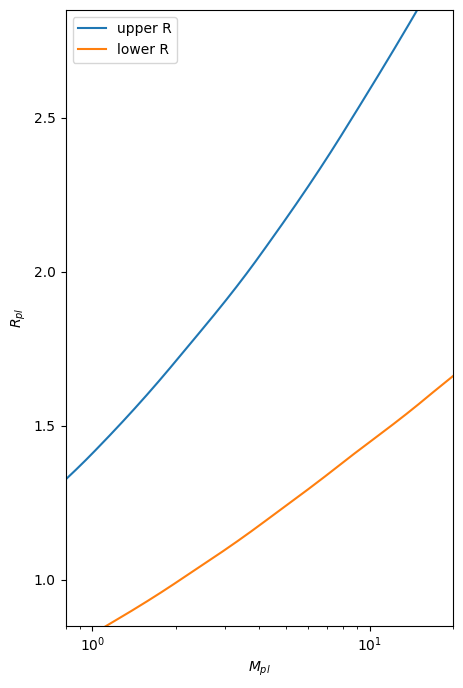

In [24]:
import matplotlib.pyplot as plt
rs = np.linspace(0.776, 2.85, 1000)
plt.figure(figsize=(5,8))
plt.plot(upperf(rs), rs, label="upper R")
plt.plot(lowerf(rs), rs, label="lower R")
plt.legend()
plt.xscale('log')
plt.ylim(0.85, 2.85)
plt.xlim(0.8, 20)
plt.yticks([1,1.5,2,2.5])
plt.ylabel(r"$R_{pl}$")
plt.xlabel(r"$M_{pl}$")
plt.show()

In [7]:
dict = {'M_pl': {'input_unit': "pRT_M_earth",
  'unit': "g",
  'input_truth': 1.0,
  'truth': 5.972167867791379e+27,
  'prior': {'kind': '2d-uniform',
   'input_prior_specs': {'mean': 1, 'sigma': 0.2}},
  'type': 'PHYSICAL PARAMETERS'}}

In [8]:
from pyretlife.retrieval.priors import assign_priors
f = assign_priors(dict)

In [9]:
f

{'M_pl': {'input_unit': 'pRT_M_earth',
  'unit': 'g',
  'input_truth': 1.0,
  'truth': 5.972167867791379e+27,
  'prior': {'kind': '2d-uniform',
   'input_prior_specs': {'mean': 1, 'sigma': 0.2},
   'function': <function pyretlife.retrieval.priors.twod_uniform_prior(r: float, R_pl: int) -> float>},
  'type': 'PHYSICAL PARAMETERS'}}

In [10]:
f['M_pl']['prior']["function"](0.5, 1)

7.393656200525137e+27

In [ ]:
import numpy as np

output_spec_path = '/mnt/c/Users/timlf/PycharmProjects/Semester_Project_Too/VH2O_P10_noise.txt'
reference_SNR = 20  # target SNR at reference wavelength
reference_wl = 11.25  # wavelength (in um) where SNR should be set to target

spec_resolution = 100  # spectral resolving power R of input spectrum
min_wavelength = 4.0  # short wavelength cutoff for output spectrum (in um)
max_wavelength = 18.5  # long wavelength cutoff for output spectrum (in um)

params_init = pipeline.get_resource('params_init')
sed_init = params_init.params[0].sed.cpu().numpy()[:-1]  # Convert to numpy array from a torch Tensor
sed_init /= 1e6  # Convert to ph s-1 m-2 um-1
wavelengths = params_init.params[0].sed_wavelength_bin_centers.cpu().numpy()  # Convert to Torch tensor
wavelengths *= 1e6  # Convert from m to um

input_spec_rebin = np.loadtxt(output_spec_path)
plt.figure()
plt.errorbar(
    input_spec_rebin[:,0],
    input_spec_rebin[:,1],
    yerr=input_spec_rebin[:,2],
    fmt='o',
    ecolor='gray',
    alpha=0.8,
    zorder=1,
    capsize=1.5,
    capthick=0.5,
    linewidth=0.5
)
plt.xlabel(r'$\lambda$ [$\mu$m]')
plt.ylabel(r'Flux [erg s$^{-1}$ Hz$^{-1}$ m$^{-2}$]')

plt.fill_between(
    wavelengths[:-1],
    np.array(sed_init) - np.array(sed_err_low)[:-1],
    np.array(sed_init) + np.array(sed_err_high)[:-1],
    color='dodgerblue',
    edgecolor=None,
    lw=0,
    alpha=0.2,
    label='1$\sigma$',
    zorder=0
)

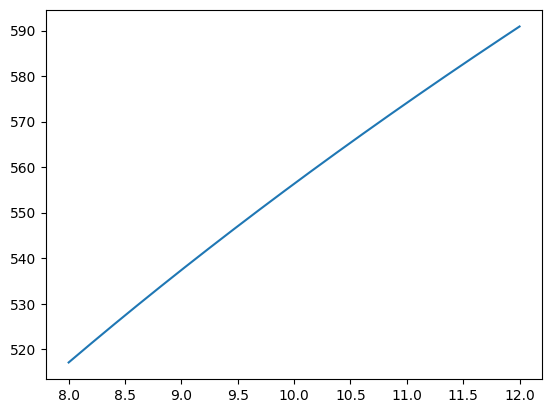

In [1]:
import numpy as np
import matplotlib.pyplot as plt
temp_vars={'a_0': 285.22,
           'a_1': 146.63,
           'a_2': 99.7,
           'a_3': 23.12,
           'a_4': 1.67,}

pressure=np.linspace(8,12,1000)

temperature = np.array(
    np.polyval(
        np.array(
            [
                temp_vars["a_" + str(len(temp_vars) - 1 - i)]
                for i in range(len(temp_vars))
            ]
        ),
        np.log10(pressure),
    )
)

plt.plot(pressure, temperature)